The purpose of this notebook is to investigate the effects of different clustering levels in the train-test split on results. The main idea is that higher degrees of clustering mean more of the evolutionary history is not shared between training and test sets, making it harder for the embedding model to simply memorize distances between pairs of sequences.

# Imports and definitions

In [7]:
%load_ext autoreload

import pickle
import pandas as pd
import tensorflow as tf

from utils.preprocessing import process_seqs
from model.train_model import train_siamese_model
from model.models_cstm import get_embedding_model


def test_split(seqs_path, y_path, depth):
    """
    Helper function for generating cladistic train-test split analysis. The idea is to vary the depth,
    keeping other variables consistent. 
    """
    # Load data from known y matrix
    data = process_seqs(
        seqs_path=seqs_path,
        train_test_split='distance',
        split_depth=depth,
        test_size=0.2,
        val_size=0.2,
        load_y=y_path,
        verbose=True
    )
    
    # Get input/output sizes
    in_dim = data[0][0].shape[1]
    hidden_dim = int(in_dim * 0.75)
    out_dim = int(in_dim * 0.5)
    
    # Specifying model this way keeps hyperparameters consistent
#     optimizer = tf.keras.optimizers.Adam(
#         learning_rate=1e-2, 
#     )
    optimizer = tf.keras.optimizers.Adam( # hyperbolic hyperparams
        learning_rate=1,
        clipnorm=1
    )
    model, score, history = train_siamese_model(
        data,
        embedding_model=get_embedding_model(
            in_dim=in_dim, 
            out_dim=out_dim,
            model_choice='LINEAR',
#             mlp_num_units_hidden=hidden_dim
        ),
        optimizer=optimizer,
        distance_metric='hyperbolic',
        epochs=1,
        batch_size=1024,
    )
    return model, score, history

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# PheS case

In [3]:
!mkdir ./data/phes
!wget -O ./data/phes/phes_na.fa https://www.dropbox.com/s/fdto3lznea8zqyk/phes_na.fa
!wget -O ./data/phes/y.pkl https://www.dropbox.com/s/8nt968mahec1urf/y.pkl?dl=0

mkdir: cannot create directory ‘./data/phes’: File exists
--2021-12-20 06:48:47--  https://www.dropbox.com/s/fdto3lznea8zqyk/phes_na.fa
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6019:18::a27d:412
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/fdto3lznea8zqyk/phes_na.fa [following]
--2021-12-20 06:48:48--  https://www.dropbox.com/s/raw/fdto3lznea8zqyk/phes_na.fa
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4a656025959d0216666741cf57.dl.dropboxusercontent.com/cd/0/inline/BcMdLoSqQo_I898x2oAXDi3rj-2FN10RGD4PMrq5GaEYZ2T1pCaIYAMqw4uvwu-xIXtCjGX6m6dMh8d9AolrcVlIB0yBW76eb5p91P9HjcZMcnjUn9pSizvFZp9jDYwIOuTQyfCY-SgGwVI862RWwOwb/file# [following]
--2021-12-20 06:48:48--  https://uc4a656025959d0216666741cf57.dl.dropboxusercontent.com/cd/0/inline/BcMdLoSqQo_I898x2oAXDi3rj-2FN10RGD4PMr

In [4]:
phes_fasta_path = "./data/phes/phes_na.fa"
phes_y_path = "./data/phes/y.pkl"
history_path="./results/train_test/phes"

In [5]:
!mkdir ./results/train_test/phes

mkdir: cannot create directory ‘./results/train_test/phes’: File exists


In [8]:
scores = pd.DataFrame(columns=["depth", "score"])
for depth in range(1,9):
    # Running function
    print(f"DEPTH = {depth}:", "#"*100)
    model, score, history = test_split(phes_fasta_path, phes_y_path, depth)
    print(f"\tSCORE: {score}")
    
    # Saving
    model.save(f"{history_path}/model_{depth}.tf", save_format="tf")
    pd.DataFrame(history.history).to_pickle(f"{history_path}/history_{depth}.pkl")
    scores = scores.append({"depth" : depth, "score" : score}, ignore_index=True)

scores.to_pickle(f"{history_path}/scores.pkl")

DEPTH = 1: ####################################################################################################
Reading inputs...
	Done in 3.342 seconds
	Shape of X: (7010, 1821)
Loading distances from ./data/phes/y.pkl
Splitting X values...
	Done in 0.750 seconds
	Shapes of data: (4205, 1821), (1402, 1821), (1403, 1821)
Epoch 1/2
17263/17263 [==============================] - 319s 18ms/step - loss: 326065.0625 - val_loss: 320453.6562
Epoch 2/2
1918/1918 [==============================] - 22s 12ms/step - loss: 314984.3750
	SCORE: 314984.375
INFO:tensorflow:Assets written to: ./results/train_test/phes/model_1.tf/assets
DEPTH = 2: ####################################################################################################
Reading inputs...
	Done in 3.257 seconds
	Shape of X: (7010, 1821)
Loading distances from ./data/phes/y.pkl
Splitting X values...
	Done in 0.543 seconds
	Shapes of data: (4206, 1821), (1402, 1821), (1402, 1821)
Epoch 1/2
17271/17271 [============================

Epoch 1/2
16180/16180 [==============================] - 293s 18ms/step - loss: 342008.5312 - val_loss: 172493.0781
Epoch 2/2
1956/1956 [==============================] - 22s 11ms/step - loss: 357259.4062
	SCORE: 357259.40625
INFO:tensorflow:Assets written to: ./results/train_test/phes/model_8.tf/assets


# 16S rRNA case

In [9]:
!mkdir ./data/16s
!wget -O ./data/16s/16s_na.fa https://www.dropbox.com/s/uauwqmdjy41rf9t/16s_na.fa
!wget -O ./data/16s/y.pkl https://www.dropbox.com/s/598zhxhlhjq5hhh/y.pkl

--2021-12-20 08:17:36--  https://www.dropbox.com/s/uauwqmdjy41rf9t/16s_na.fa
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/uauwqmdjy41rf9t/16s_na.fa [following]
--2021-12-20 08:17:36--  https://www.dropbox.com/s/raw/uauwqmdjy41rf9t/16s_na.fa
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucfe1c41f4bef4d63e16b84f0d6c.dl.dropboxusercontent.com/cd/0/inline/BcPGWiCZ7gB6qZqo6MIrJiPmwmsbWeSVpUOOR92PoMDC-GMx6GVM8o6O44lssxNIUCUnKVf1bjdU2RuyicvJtHn-WObN0j5Ydbtu2hpE18QYwdlBlCYHTKwrq4XVeIP0oYeAJ-wmYrkQt8xGaHkC-W43/file# [following]
--2021-12-20 08:17:36--  https://ucfe1c41f4bef4d63e16b84f0d6c.dl.dropboxusercontent.com/cd/0/inline/BcPGWiCZ7gB6qZqo6MIrJiPmwmsbWeSVpUOOR92PoMDC-GMx6GVM8o6O44lssxNIUCUnKVf1bjdU2RuyicvJtHn-WObN0j5Ydbt

In [3]:
rna_fasta_path = "./data/16s/16s_na.fa"
rna_y_path = "./data/16s/y.pkl"
history_path="./results/train_test/16s"

In [11]:
!mkdir ./results/train_test/16s

In [ ]:
scores = pd.DataFrame(columns=["depth", "score"])
for depth in range(1,9):
    # Running function
    print(f"DEPTH = {depth}:", "#"*100)
    model, score, history = test_split(rna_fasta_path, rna_y_path, depth)
    print(f"\tSCORE: {score}")
    
    # Saving
    model.save(f"{history_path}/model_{depth}.tf", save_format="tf")
    pd.DataFrame(history.history).to_pickle(f"{history_path}/history_{depth}.pkl")
    scores = scores.append({"depth" : depth, "score" : score}, ignore_index=True)

scores.to_pickle(f"{history_path}/scores.pkl")

DEPTH = 1: ####################################################################################################
Reading inputs...
	Done in 10.517 seconds
	Shape of X: (16861, 3232)
Loading distances from ./data/16s/y.pkl
Splitting X values...
	Done in 4.144 seconds
	Shapes of data: (10117, 3232), (3372, 3232), (3372, 3232)
5550/5550 [==============================] - 171s 31ms/step - loss: 677472.3750
	SCORE: 677472.375
INFO:tensorflow:Assets written to: ./results/train_test/16s/model_1.tf/assets
DEPTH = 2: ####################################################################################################
Reading inputs...
	Done in 21.561 seconds
	Shape of X: (16861, 3232)
Loading distances from ./data/16s/y.pkl
Splitting X values...
	Done in 4.345 seconds
	Shapes of data: (10113, 3232), (3374, 3232), (3374, 3232)
49932/49932 [==============================] - ETA: 0s - loss: 695190.7500

This analysis ended up crashing every machine I tried doing it with, so I skipped it. Instead, I will simply comment on the results for PheS.

# Plotting

In [4]:
!pip install matplotlib

     |████████████████████████████████| 7.3 MB 3.2 MB/s            
     |████████████████████████████████| 61 kB 567 kB/s             
     |████████████████████████████████| 3.0 MB 8.4 MB/s            
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
     |████████████████████████████████| 890 kB 12.5 MB/s            


In [6]:
import matplotlib.pyplot as plt
import pandas as pd

history_path="./results/train_test/phes"
scores = pd.read_pickle(f"{history_path}/scores.pkl")

Text(0.5, 0, 'Split depth')

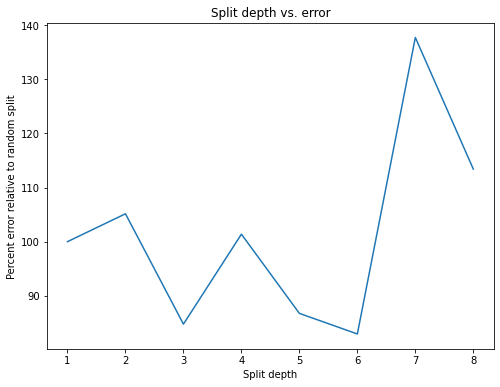

In [17]:
score_0 = scores.iloc[0]["score"]

fig = plt.figure(figsize=(8,6))
plt.plot(scores["depth"], scores["score"] / score_0 * 100)
plt.title("Split depth vs. error")
plt.ylabel("Percent error relative to random split")
plt.xlabel("Split depth")

In [34]:
# Also include training and validation loss, read from previous data:

scores_detailed = scores.copy()
scores_detailed["val_loss"] = 0
scores_detailed["train_loss"] = 0

for n in range(1,9):
    history = pd.read_pickle(f"{history_path}/history_{n}.pkl")
    train_loss = history.iloc[1]["loss"]
    val_loss = history.iloc[1]["val_loss"]
    scores_detailed.loc[n-1, "train_loss"] = train_loss
    scores_detailed.loc[n-1, "val_loss"] = val_loss

scores_detailed

,depth,score,val_loss,train_loss
0,1.0,314984.375000,318818.062500,322911.53125
1,2.0,331213.406250,323671.250000,315706.56250
2,3.0,266960.031250,350302.031250,327281.96875
3,4.0,319334.281250,289694.218750,329922.37500
4,5.0,273219.875000,362206.593750,320830.00000
5,6.0,261226.640625,414230.500000,301813.84375
6,7.0,433890.406250,220746.906250,307345.62500
7,8.0,357259.406250,171239.015625,338811.25000


In [44]:
scores_detailed.columns = ["Depth", "Test", "Validation", "Training"]
scores_detailed /= scores_detailed.iloc[0]
scores_detailed[["Test", "Validation", "Training"]] *= 100
scores_detailed

,Depth,Test,Validation,Training
0,1.0,100.000000,100.000000,100.000000
1,2.0,105.152329,101.522244,97.768748
2,3.0,84.753420,109.875215,101.353447
3,4.0,101.380991,90.865058,102.171135
4,5.0,86.740771,113.609182,99.355387
5,6.0,82.933206,129.926923,93.466419
6,7.0,137.749819,69.239147,95.179514
7,8.0,113.421311,53.710575,104.923862


Text(0.5, 0, 'Split depth')

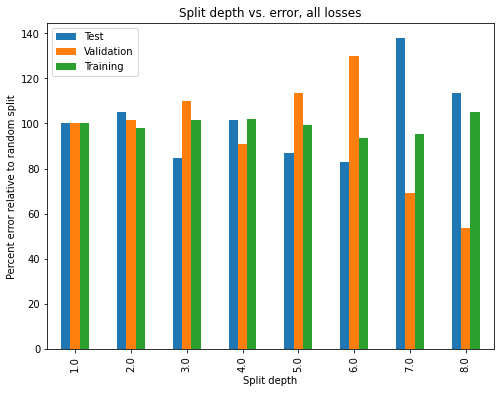

In [49]:
scores_detailed.plot(kind="bar", x="Depth", figsize=(8,6))
plt.title("Split depth vs. error, all losses")
plt.ylabel("Percent error relative to random split")
plt.xlabel("Split depth")